In [16]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

r = requests.get("http://google.com")
print(r.status_code)

# 200

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200


In [17]:
class Replaybuffer:
    def __init__(self,n_state,n_action):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 #记忆池大小
        self.batchsize = 10

        #给记忆五元组申请空间
        self.s = np.empty(shape = (self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape = (self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # 初始化tmax属性 ##后加

    def add_memo(self,s,a,r,done,s_): #需要实现功能：1.交互后增加记忆 2.sample batch时取出记忆
    #第t步向记忆池里加记忆
        #print("s:", s.shape)  # 打印s的形状
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 #t到2001时，重新从1开始加
        self.tmax = max(self.tmax, self.t +1)



    def sample(self):
    #采样逻辑：Buffer里的经验如果比batchsize多，那就sample;如果比batchsize少，那就有几个取几个
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax),self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # 如果缓冲区样本数大于等于批次大小，使用批次大小
        else:
           k = self.tmax  # 否则，使用缓冲区的实际样本数量

        idxes = random.sample(range(0, self.tmax), k)  # 使用确定的k值抽样

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: #抽64个数据
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        #把numpy转换成torch的tensor
        batch_s = torch.as_tensor(np.asarray(batch_s),dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a),dtype=torch.int64).unsqueeze(-1) #升维：从(2)升到(2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r),dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done),dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_),dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_

In [18]:
class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() #继承Module父类

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self,x):
           return self.net(x) #前向传播

      def act(self,obs): #面对s，找到最大的Q值（因为神经网络输出的不只是最大Q值），输出对应的action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) #转化成行向量
          max_q_idx = torch.argmax(input=q_value)
          action = max_q_idx.detach().item() #最大Q值索引对应的action
          return action


class AgentwoRB:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.001):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma

            #self.Gamma = 0.97
            #self.learning_rate = 0.01

            #self.memo = Replaybuffer(self.n_input, self.n_output) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),
                                              lr=self.learning_rate)

class AgentwRB:
   def __init__(self, n_input, n_output, Gamma=0.97, learning_rate = 0.001):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma

            self.memo = Replaybuffer(self.n_input, self.n_output) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),
                                              lr=self.learning_rate)


In [19]:
class LearningCurvePlot:

    def __init__(self,title=None):
        self.fig,self.ax = plt.subplots()
        self.ax.set_xlabel('Timestep')
        self.ax.set_ylabel('Episode Return')
        if title is not None:
            self.ax.set_title(title)

    def add_curve(self,x,y,label=None):
        ''' y: vector of average reward results
        label: string to appear as label in plot legend '''
        if label is not None:
            self.ax.plot(x,y,label=label)
        else:
            self.ax.plot(x,y)

    def set_ylim(self,lower,upper):
        self.ax.set_ylim([lower,upper])

    def add_hline(self,height,label):
        self.ax.axhline(height,ls='--',c='k',label=label)

    def save(self,name='test.png'):
        ''' name: string for filename of saved figure '''
        self.ax.legend()
        self.fig.savefig(name,dpi=300)


    def show_legend(self):
        plt.legend()

    def show_plot(self):
        self.show()



Episode 0, Reward: 10.0
Episode 10, Reward: 9.0
Episode 20, Reward: 8.0
Episode 30, Reward: 10.0
Episode 40, Reward: 8.0
Episode 50, Reward: 11.0
Episode 60, Reward: 9.0
Episode 70, Reward: 9.0
Episode 80, Reward: 10.0
Episode 90, Reward: 10.0
Episode 100, Reward: 10.0
Episode 110, Reward: 9.0
Episode 120, Reward: 10.0
Episode 130, Reward: 10.0
Episode 140, Reward: 10.0
Episode 150, Reward: 10.0
Episode 160, Reward: 10.0
Episode 170, Reward: 10.0
Episode 180, Reward: 8.0
Episode 190, Reward: 10.0
Episode 200, Reward: 10.0
Episode 210, Reward: 10.0
Episode 220, Reward: 10.0
Episode 230, Reward: 8.0
Episode 240, Reward: 10.0
Episode 250, Reward: 9.0
Episode 260, Reward: 10.0
Episode 270, Reward: 10.0
Episode 280, Reward: 10.0
Episode 290, Reward: 10.0
Episode 300, Reward: 9.0
Episode 310, Reward: 10.0
Episode 320, Reward: 9.0
Episode 330, Reward: 11.0
Episode 340, Reward: 10.0
Episode 350, Reward: 10.0
Episode 360, Reward: 8.0
Episode 370, Reward: 10.0
Episode 380, Reward: 8.0
Episode 39

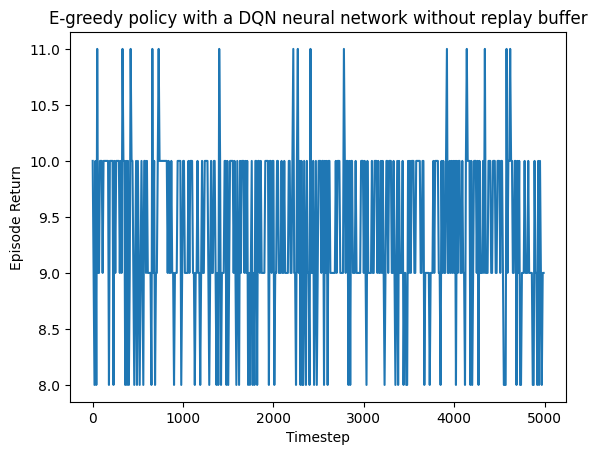

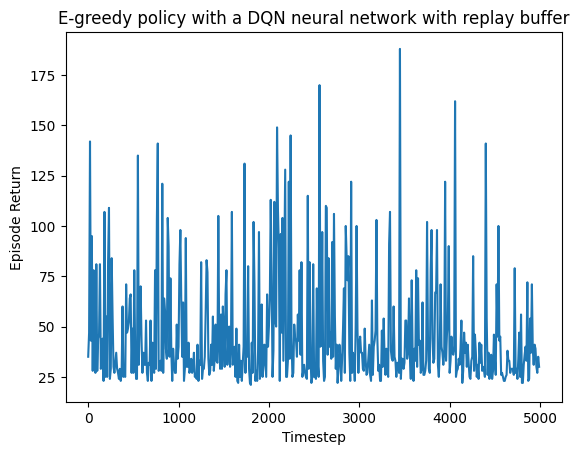

In [23]:
env = gym.make('CartPole-v1')

episode_array = []
rewards_array = []


Plot = LearningCurvePlot(title = 'E-greedy policy with a DQN neural network without replay buffer')


n_input = env.observation_space.shape[0]
n_output = env.action_space.n

agent = AgentwoRB(n_input, n_output)



num_episodes = 5000
for i_episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.online_net.act(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

    if i_episode % 10 == 0:
        print(f"Episode {i_episode}, Reward: {episode_reward}")
        episode_array.append(i_episode)
        rewards_array.append(episode_reward)

Plot.add_curve(episode_array,rewards_array,label=r'DQN neural network without replay buffer')

Plot2 = LearningCurvePlot(title = 'E-greedy policy with a DQN neural network with replay buffer')

agent = AgentwRB(n_input, n_output)
episode_array = []
rewards_array = []

num_episodes = 5000
for i_episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    while not done:
        action = agent.online_net.act(state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

    if i_episode % 10 == 0:
        print(f"Episode {i_episode}, Reward: {episode_reward}")
        episode_array.append(i_episode)
        rewards_array.append(episode_reward)

Plot2.add_curve(episode_array,rewards_array,label=r'DQN neural network with replay buffer')


env.close()